# Models 2

In this notebook, we conduct a correlation analysis to identify highly correlated variables within the dataset. Despite the presence of strong correlations, initial model evaluations show that performance remains high even when all variables are retained. This suggests that, although some features are highly correlated, eliminating them might lead to a loss of valuable information. To enhance interpretability, we apply PCA to identify groups of related variables within the dataset, which consists of 32 features. Following this, we evaluate the significance and relevance of the principal components by:  
1. Fitting a linear regression model to assess whether the extracted components are statistically significant.  
2. Training a decision tree model to analyze the importance of each principal component in predicting the target variable.  

In [1]:
#Libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.svm import SVR
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

We retrieve some functions programmed in the script 3-Models:

In [2]:
data_path = "transformed_features.csv" # your features_df data path

def load_train_val_splits(data_path="data/transformed_df", target="num_sold"):
    df = pd.read_csv(data_path,index_col=0)
    df_numeric = df.select_dtypes(include=[float, int]).drop(columns=["id"]).dropna()

    train_df = df_numeric[df_numeric["test"] == 0]
    test_df = df_numeric[df_numeric["test"] == 1]

    X_train = train_df.drop(columns=[target,"test"])
    X_test = test_df.drop(columns=[target,"test"])

    y_train = train_df[target]
    y_test = test_df[target]
    
    return X_train, X_test, y_train, y_test # No shuffle, avoid data leakage in temporal data

In [3]:
# helper function to get testing metrics
def validate_model(model, X_val, y_val):

    # predictions
    y_pred = model.predict(X_val)
    
    # metrics
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val,y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Percentage Error {mape}")
    
    return {"mse": mse, "mae": mae, "r2": r2, "mape":mape}

In [4]:
class BaggingEnsemble():
    '''Bagging ensemble model for regression.
    
    This class implements a bagging ensemble model for regression tasks. 
    It supports both hard and soft voting strategies, although only soft voting is implemented for regression.
    
    Attributes:
        voting (str): Voting strategy, either "hard" or "soft". Default is "hard".
        model_list (list): List of regression models to be used in the ensemble.
    '''
    
    def __init__(self, voting="hard", model_list=[]):
        self.model_list = model_list
        self.voting = voting
    
    def fit(self, X_train, y_train):
        '''
        Fits each model in the ensemble to the training data.
        '''
        for model in self.model_list:
            model.fit(X_train, y_train)
    
    def predict(self, X_test):
        '''
        Predicts the target variable for the test data using the ensemble of models.
        '''
        if self.voting == "soft":
            return np.mean([model.predict(X_test) for model in self.model_list], axis=0) # return the mean of all predictions
        elif self.voting == "hard":
            raise NotImplementedError("Hard voting not implemented for regression ensemble")
        else:
            raise ValueError("Unrecognized voting strategy: use hard or soft.")

In [5]:
class EnsembleRegressionModel():
    '''Boost Ensemble Regression Model. 
    1. Fits a linear regression model with features X and target y, then calculates the resulting residuals.
    2. Fits another regression model with same feature set X and residuals as target variable (captures and corrects non linearities and errors from the first model).
    3. Computes the final prediction as the sum of the linear regression output and the residuals predicted by the second model.'''
    def __init__(self,top_model="xgboost",regressor="linear",regression_params={},top_model_params={},name=None):

        self.name=name # Add a verbous name for the model
        
        self.regression_params = regression_params
        self.top_model_params = top_model_params
        
        self.implemented_regressors = {
            "linear": LinearRegression,
            "svr":SVR # SVR takes to long to train, 
            # You can add other regression models here if desired. 
            # However, we highly recommend using linear regression, as it aligns with our feature engineering and insights, 
            # and also follows Occam's Razor (favoring simplicity).
        }
        self.regressor= self.implemented_regressors.get(regressor)
        
        self.implemented_top_models = {
            "xgboost":XGBRegressor,
            "random_forest":RandomForestRegressor,
            "bagging":BaggingEnsemble  # a custom ensemble model that computes the average of several models
            # here you can add other models to try (ej: transformer, random forest)
        }
        self.top_model=self.implemented_top_models.get(top_model)

        # Placeholders for the fitted models
        self.base_model = None
        self.top_model_instance = None
        
    def _train_regression(self,X, y):
        '''Trains the base linear regression model and computes residuals.'''
        self.base_model = self.regressor(**self.regression_params)
        self.base_model.fit(X, y)
        y_pred = self.base_model.predict(X)
        self.residuals = y - y_pred

    def _train_top_model(self,X):
        '''Trains the top model on the residuals from the linear regression.'''
        self.top_model_instance = self.top_model(**self.top_model_params)
        self.top_model_instance.fit(X, self.residuals)

    def fit(self,X_train,y_train):
        '''Trains both the base and residual models.'''
        self._train_regression(X_train, y_train)
        self._train_top_model(X_train)
    
    def predict(self,X_test):
        '''Makes predictions by summing the base regressor predictions and the residual model predictions.'''
        base_pred = self.base_model.predict(X_test)
        residual_pred = self.top_model_instance.predict(X_test)
        return base_pred + residual_pred
    
    def evaluate(self,X_test,y_test):
        '''Shows and returns regression metrics.'''
        y_pred = self.predict(X_test)
    
        # metrics
        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        
        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"R^2 Score: {r2}")
        print(f"Mean Absolute Percentage Error {mape}")
        
        return {"mse": mse, "mae": mae, "r2": r2, "mape":mape}

In [6]:
# try different model hyperparameters if desired

top_model_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "learning_rate": 0.1,
    "random_state": 42
}

regression_params = {
    "fit_intercept": True,
}

my_boosting_model = EnsembleRegressionModel(top_model="xgboost",
                                            regressor="linear",
                                            regression_params=regression_params,
                                            top_model_params=top_model_params,
                                            name="xgboost_regression_ensemble" # just a verbous name to keep track predictions later
                                            )

In [7]:
#More models + hyperparameters

# SVR REGRESSOR + RANDOM FOREST
# my_SVR_boosting_model = EnsembleRegressionModel(top_model="xgboost",
#                                             regressor="svr",
#                                             top_model_params=top_model_params,
#                                             name="svr_regression_ensemble")


# LINEAR REGRESSION + CUSTOM BAGGING REGRESSOR
bagging_params = {
    "voting":"soft",
    "model_list": [XGBRegressor(),RandomForestRegressor()]
}

linear_bagging_model = EnsembleRegressionModel(top_model="bagging",
                                            regressor="linear",
                                            top_model_params=bagging_params,
                                            name="xgboost_rf_bagging_ensemble"
                                            )


# LINEAR REGRESSION + RANDOM FOREST REGRESSOR
top_model_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "random_state": 42
}
my_rf_boosting_model = EnsembleRegressionModel(top_model="random_forest",
                                            regressor="linear",
                                            regression_params=regression_params,
                                            top_model_params=top_model_params,
                                            name="random_forest_regression_ensemble")




# Add single models to compare performance when we do not use ensmeble combination

xgboost_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "learning_rate": 0.1,
    "random_state": 42
} # tune hyperparameters as you prefer

xgboost_basic = XGBRegressor(**xgboost_params)

linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor(max_depth=10)
bagging_model = BaggingEnsemble(voting="soft", model_list=[XGBRegressor(),RandomForestRegressor()])


# Model list
my_model_list = [
    my_boosting_model,
    my_rf_boosting_model,
    # my_SVR_boosting_model,
    linear_bagging_model,
    # more models
    # you can also add other sklearn instances
    xgboost_basic,
    linear_regression,
    decision_tree,
    bagging_model 
]

In [35]:
def get_model_predictions_df(model_list):
    pred_df = pd.DataFrame()
    error_metrics_train = pd.DataFrame()
    error_metrics_val = pd.DataFrame()
    for model in model_list:
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        model_name = model.name + "_pca" if hasattr(model, 'name') else type(model).__name__ + "_pca"
        error_metrics_val[model_name] = pd.Series(validate_model(model=model,X_val=X_val,y_val=y_val))
        pred_df[model_name] = predictions
        #print("\n",model_name)
        #validate_model(model=model,X_val=X_val,y_val=y_val)
        error_metrics_train[model_name] = pd.Series(validate_model(model=model,X_val=X_train,y_val=y_train))
    return pred_df, error_metrics_train, error_metrics_val


## Correlations

Next we are going to study correlations into explicative variables

In [9]:
#Defining df and dropping the target variable, id column and test variable
df = pd.read_csv(data_path,index_col=0)
df_numeric = df.select_dtypes(include=[float, int]).drop(columns=["id", "num_sold", "test"]).dropna()
df_numeric.head()

,year,weekday,day_of_year,day_num,week_num,month,sin_2pi,cos_2pi,sin_24pi,cos_24pi,...,product_factor,holiday,weekday_factor,ratio,total,day_of_year_factor,sincos_factor,country_factor,cya_factor,till_month_end
1,2010,4,1,0,0,1,0.0,1.0,0.0,1.0,...,0.329518,1,0.142912,680.203967,1.430453,0.000613,0.000613,0.998514,1.190042,30
2,2010,4,1,0,0,1,0.0,1.0,0.0,1.0,...,0.293260,1,0.142912,605.360391,1.496629,0.000613,0.000613,0.998514,1.190042,30
3,2010,4,1,0,0,1,0.0,1.0,0.0,1.0,...,0.149004,1,0.142912,307.580146,1.375251,0.000613,0.000613,0.998514,1.190042,30
4,2010,4,1,0,0,1,0.0,1.0,0.0,1.0,...,0.175473,1,0.142912,362.218380,1.355536,0.000613,0.000613,0.998514,1.190042,30
5,2010,4,1,0,0,1,0.0,1.0,0.0,1.0,...,0.052415,1,0.142912,218.875792,1.370640,0.000613,0.000613,0.998514,1.190042,30


In [10]:
#Calculating the correlation matrix
correlation_matrix = df_numeric.corr()
correlation_matrix

,year,weekday,day_of_year,day_num,week_num,month,sin_2pi,cos_2pi,sin_24pi,cos_24pi,...,product_factor,holiday,weekday_factor,ratio,total,day_of_year_factor,sincos_factor,country_factor,cya_factor,till_month_end
year,1.000000,-0.000602,0.000032,0.989632,0.989629,-0.001142,0.000517,-0.000384,-0.000024,-0.000087,...,-0.007587,-0.001631,-0.001402,-0.051717,0.137784,0.000511,-0.001927,-0.017134,-0.011946,0.000645
weekday,-0.000602,1.000000,-0.003460,-0.001094,0.000267,-0.003621,0.000467,-0.000838,-0.000001,0.000838,...,-0.008522,0.009206,0.859879,0.071910,-0.019772,-0.000130,0.000097,-0.005266,-0.007455,-0.001349
day_of_year,0.000032,-0.003460,1.000000,0.143657,0.143650,0.996525,-0.779105,-0.006237,-0.065649,-0.006914,...,-0.001079,-0.007978,-0.003815,-0.009296,0.042134,-0.621230,-0.344280,-0.000737,0.058727,-0.074200
day_num,0.989632,-0.001094,0.143657,1.000000,0.999996,0.141997,-0.111388,-0.001276,-0.009453,-0.001079,...,-0.007664,-0.002761,-0.001936,-0.052509,0.142386,-0.088719,-0.051273,-0.017063,-0.003389,-0.010019
week_num,0.989629,0.000267,0.143650,0.999996,1.000000,0.141990,-0.111387,-0.001275,-0.009453,-0.001076,...,-0.007681,-0.002680,-0.000422,-0.052383,0.142345,-0.088718,-0.051272,-0.017073,-0.003407,-0.010020
month,-0.001142,-0.003621,0.996525,0.141997,0.141990,1.000000,-0.780089,-0.009406,-0.003301,0.008655,...,-0.001062,-0.003506,-0.003960,-0.009260,0.042044,-0.623948,-0.343200,-0.000727,0.058540,0.008831
sin_2pi,0.000517,0.000467,-0.779105,-0.111388,-0.111387,-0.780089,1.000000,-0.000353,0.000221,0.000096,...,0.001876,0.058948,0.000481,0.011727,0.016938,0.793189,0.457397,0.000782,0.023530,-0.007450
cos_2pi,-0.000384,-0.000838,-0.006237,-0.001276,-0.001275,-0.009406,-0.000353,1.000000,-0.000238,0.000038,...,-0.014029,0.037480,-0.001561,0.000598,0.032396,0.608673,0.150784,-0.006981,0.044775,-0.008779
sin_24pi,-0.000024,-0.000001,-0.065649,-0.009453,-0.009453,-0.003301,0.000221,-0.000238,1.000000,0.000221,...,-0.000364,-0.040227,0.000074,-0.000198,0.012433,-0.000070,0.002484,-0.000217,0.016985,0.749558
cos_24pi,-0.000087,0.000838,-0.006914,-0.001079,-0.001076,0.008655,0.000096,0.000038,0.000221,1.000000,...,-0.000286,0.075683,0.000362,-0.000148,0.094523,0.000060,0.000802,-0.000166,0.131011,0.188398


In [11]:
# Filtering correlations greater than 0.5 in absolute value
filtered_correlations = correlation_matrix[(correlation_matrix.abs() > 0.5)].dropna(how='all').dropna(axis=1, how='all')

In [12]:
# Extracting pairs of variables with high correlation without repetition
high_correlation_pairs = (
    filtered_correlations.where(np.triu(np.ones(filtered_correlations.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Renaming columns for clarity
high_correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_correlation_pairs

,Variable 1,Variable 2,Correlation
0,year,day_num,0.989632
1,year,week_num,0.989629
2,weekday,weekday_factor,0.859879
3,day_of_year,month,0.996525
4,day_of_year,sin_2pi,-0.779105
5,day_of_year,day_of_year_factor,-0.621230
6,day_num,week_num,0.999996
7,month,sin_2pi,-0.780089
8,month,day_of_year_factor,-0.623948
9,sin_2pi,day_of_year_factor,0.793189


Care must be taken when interpreting correlations, as there are ordinal variables (such as day of the year) and categorical variables (such as holiday, which indicates whether it is a holiday or not). However, continuous variables like gdp_factor and country_factor are highly correlated linearly.

The next step is to perform PCA to determine whether we can provide interpretability to the principal components.

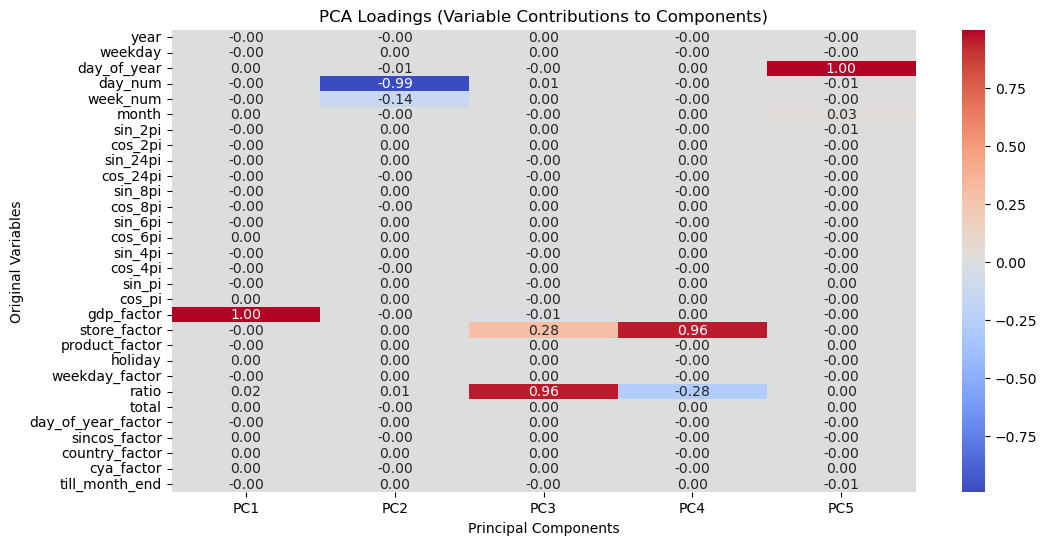

Total Explained Variance:

0.999033356163621


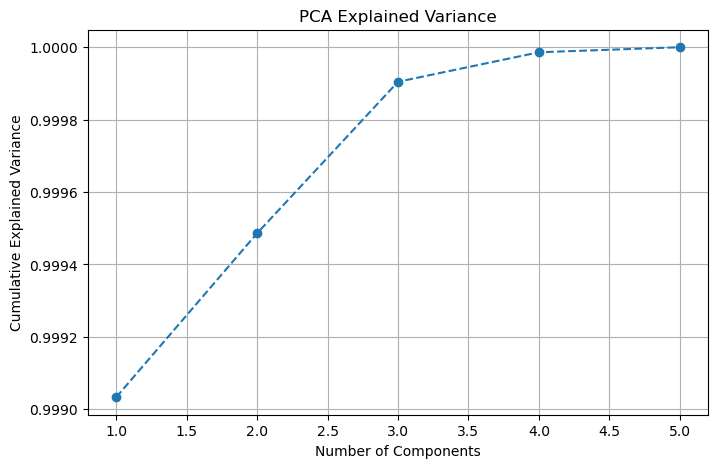

In [13]:
def load_train_val_splits_with_pca(data_path="data/transformed_df", target="num_sold", n_components=3):
    """
    Loads and splits the dataset into training and testing sets,
    applies PCA without data leakage, and standardizes after the split.
    Additionally, it displays the PCA loadings and a heatmap of variable contributions to each component.
    """
    # Load the dataset
    df = pd.read_csv(data_path, index_col=0)
    
    # Select only numerical columns and remove "id" if present
    df_numeric = df.select_dtypes(include=[float, int]).drop(columns=["id"], errors='ignore').dropna()
    
    # Split into training and testing sets based on the "test" column
    train_df = df_numeric[df_numeric["test"] == 0]
    test_df = df_numeric[df_numeric["test"] == 1]

    # Separate features and target variable
    X_train = train_df.drop(columns=[target, "test"])
    X_test = test_df.drop(columns=[target, "test"])
    
    y_train = train_df[target]
    y_test = test_df[target]

    # Apply PCA without data leakage
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)  # Fit only on training data
    X_test_pca = pca.transform(X_test)  # Transform test data using the trained PCA model

    # Convert principal components to DataFrame
    X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index, columns=[f'PC{i+1}' for i in range(n_components)])
    X_test_pca = pd.DataFrame(X_test_pca, index=X_test.index, columns=[f'PC{i+1}' for i in range(n_components)])

    # Standardization after splitting to avoid data leakage
    scaler = StandardScaler()
    X_train_pca = scaler.fit_transform(X_train_pca)  # Fit only on training data
    X_test_pca = scaler.transform(X_test_pca)  # Transform test data using the same scaler

    # Convert back to DataFrame
    X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index, columns=[f'PC{i+1}' for i in range(n_components)])
    X_test_pca = pd.DataFrame(X_test_pca, index=X_test.index, columns=[f'PC{i+1}' for i in range(n_components)])

    # Obtain PCA loadings (contributions of each variable to the principal components)
    loadings = pd.DataFrame(pca.components_, columns=X_train.columns, index=[f'PC{i+1}' for i in range(n_components)])

    # Display heatmap of PCA loadings
    plt.figure(figsize=(12, 6))
    sns.heatmap(loadings.T, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("PCA Loadings (Variable Contributions to Components)")
    plt.xlabel("Principal Components")
    plt.ylabel("Original Variables")
    plt.show()

    # Display cumulative explained variance
    print('Total Explained Variance:')
    print()
    print(pca.explained_variance_ratio_.cumsum()[0])
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid()
    plt.show()

    return X_train_pca, X_test_pca, y_train, y_test, loadings


In [14]:
# Definir la función para evaluar el modelo con diferentes números de componentes principales
def evaluate_pca_model(data_path, n_components=5):
    """
   Evaluates the achievment of a linear regression model when the number of the principal components change
    
    """
    
    # Data with PCA
    X_train, X_val, y_train, y_val, _ = load_train_val_splits_with_pca(data_path=data_path, n_components= n_components)

    # Training a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_val)

    # Calculate error metrics
    validate_model(model,X_val,y_val)
    

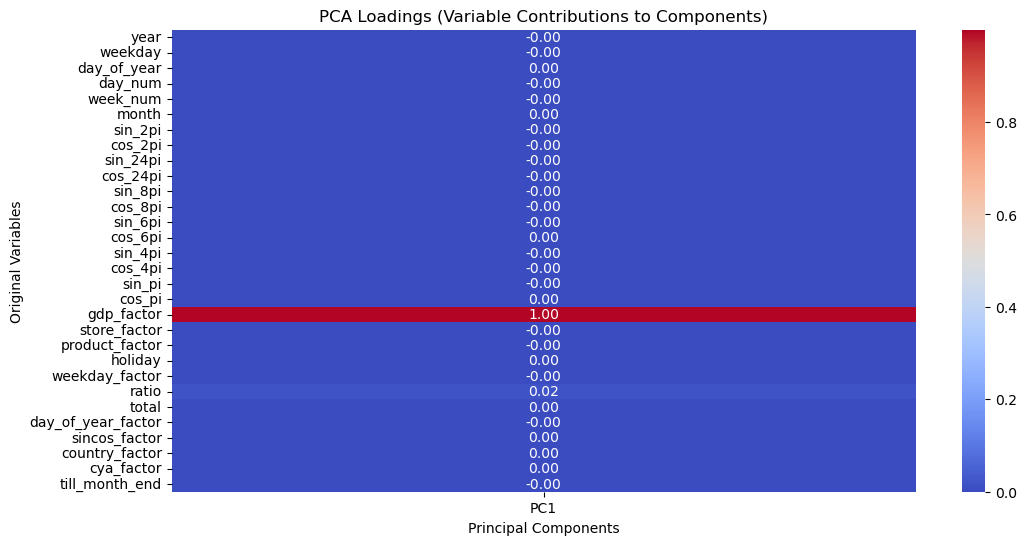

Total Explained Variance:

0.9990333561636202


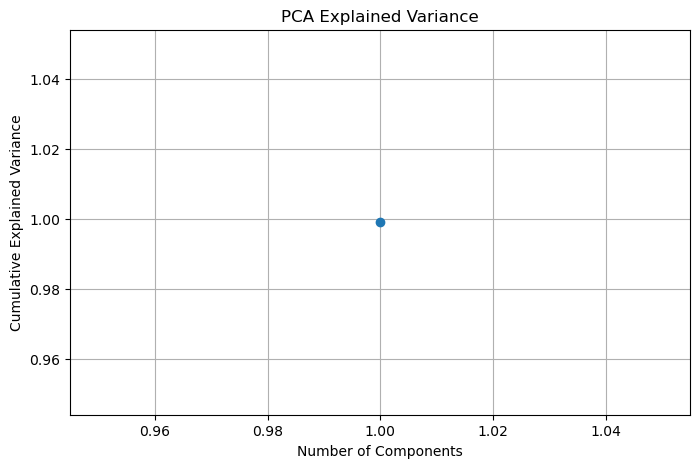

Mean Squared Error: 232463.7335161365
Mean Absolute Error: 346.5429213370119
R^2 Score: 0.34521703269800086
Mean Absolute Percentage Error 1.092495512088889


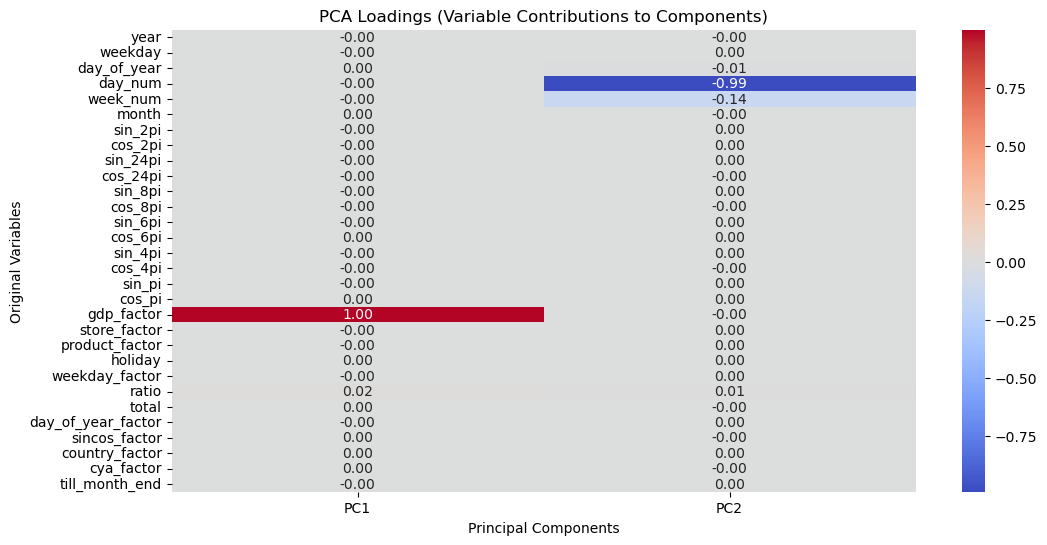

Total Explained Variance:

0.9990333561636202


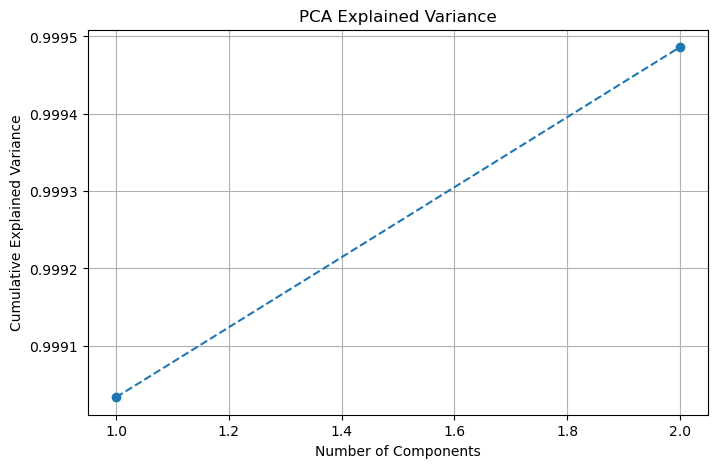

Mean Squared Error: 232708.98233960246
Mean Absolute Error: 345.5242622437426
R^2 Score: 0.34452623783754055
Mean Absolute Percentage Error 1.0383992121088486


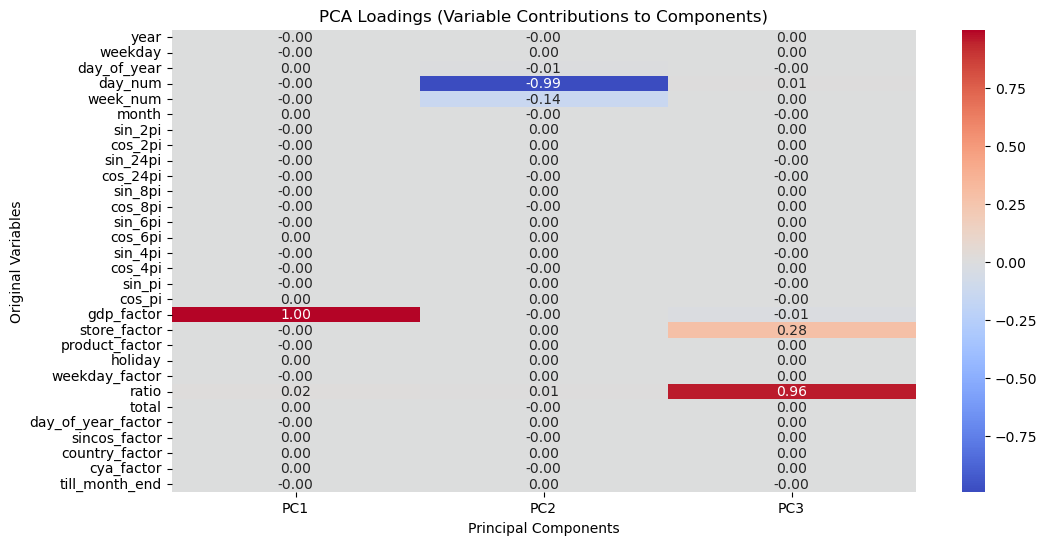

Total Explained Variance:

0.9990333561636205


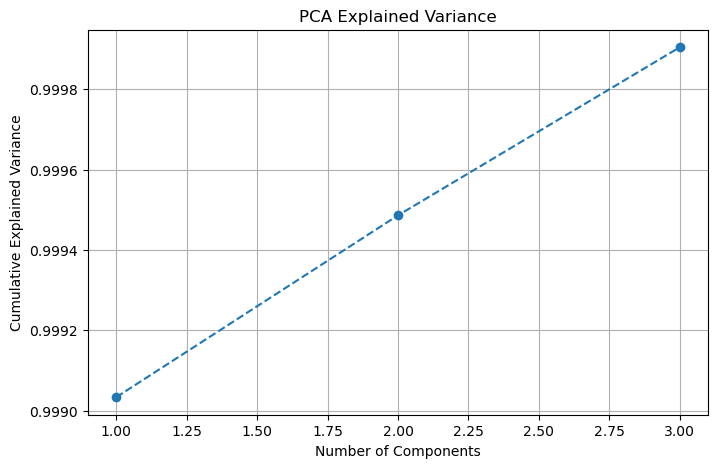

Mean Squared Error: 9736.212698928364
Mean Absolute Error: 78.53324907877278
R^2 Score: 0.972575910466287
Mean Absolute Percentage Error 0.917957603722326


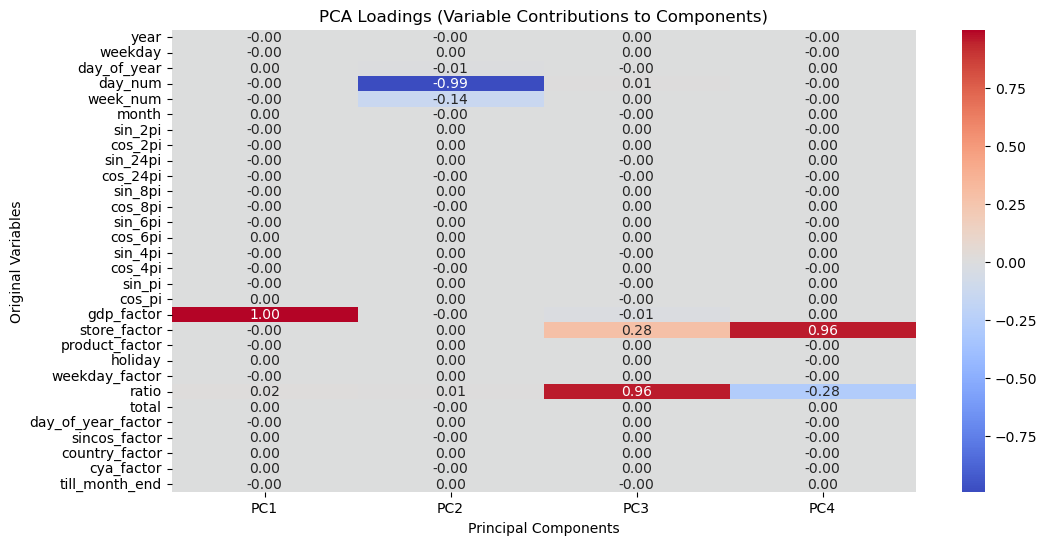

Total Explained Variance:

0.9990333561636202


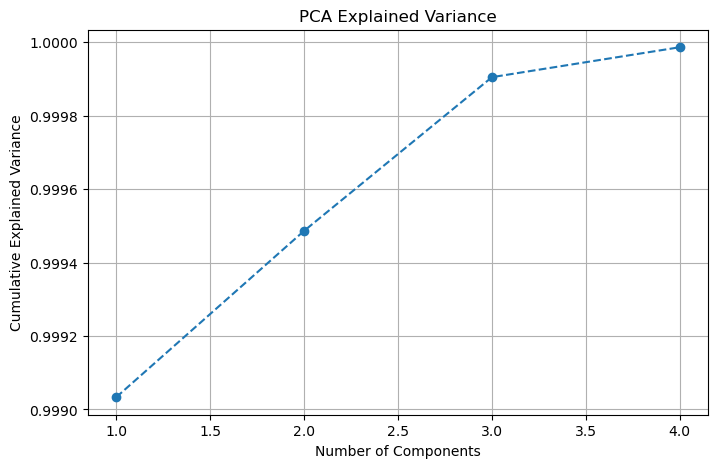

Mean Squared Error: 4986.916852900471
Mean Absolute Error: 38.00189498353982
R^2 Score: 0.9859533004772814
Mean Absolute Percentage Error 0.12441436170211931


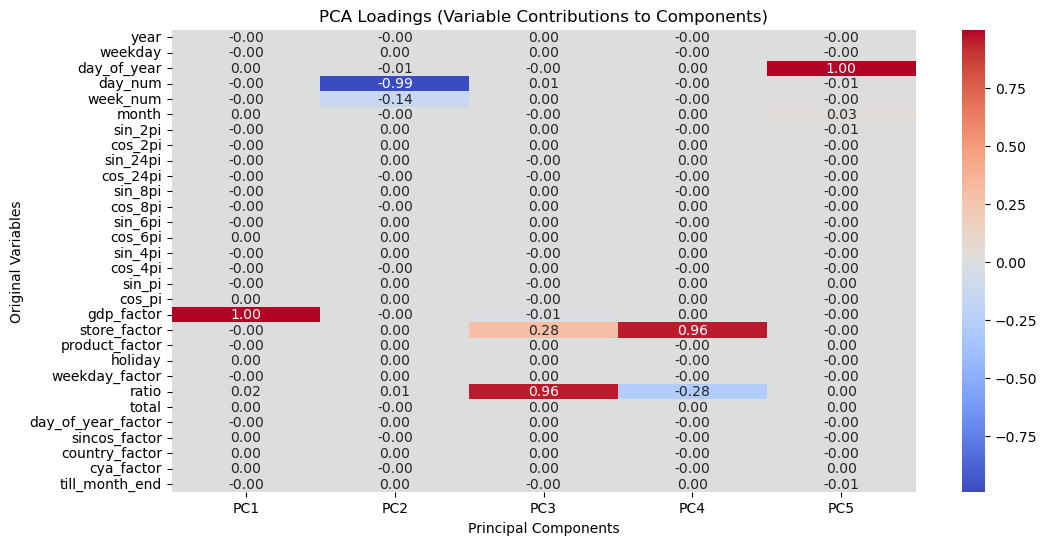

Total Explained Variance:

0.9990333561636199


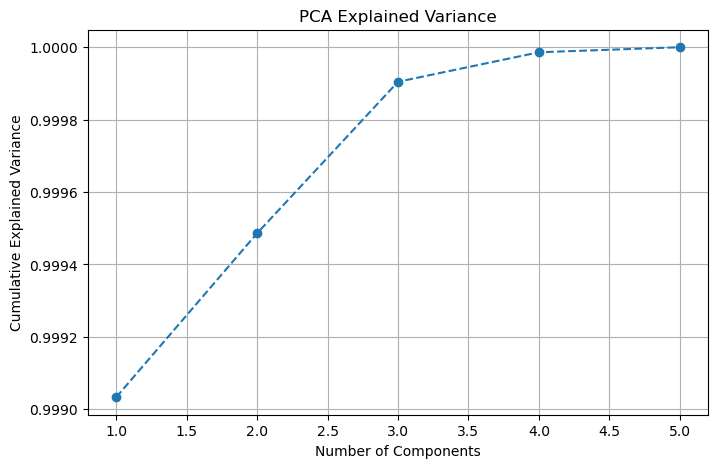

Mean Squared Error: 4979.461123043201
Mean Absolute Error: 38.00511441735768
R^2 Score: 0.9859743011075539
Mean Absolute Percentage Error 0.12635132450029277


In [15]:
components = [1,2,3,4,5]
for i in components:
    evaluate_pca_model(data_path="transformed_features.csv", n_components=i)

### Selection of the Number of Principal Components in PCA

We decided to select **4 principal components** for the following reasons:

- They explain **99.998% of the total variance**, meaning that nearly all relevant information from the dataset is retained.  
- Adding a fifth component **barely improves the model**, with only a minimal reduction in MSE (-7.46) and a marginal increase in R² (+0.00002).  
- The model shows **better performance in MAE and MAPE with four components**, suggesting that the fifth component might introduce noise rather than meaningful information.  
- The fifth component mainly captures **store-specific effects (`store_factor`)**, but its overall impact is low compared to the other components.  

The decision to use four components is supported by both the **variance explained** and the **error metrics**, which show meaningful differences when moving from three to four components. However, the inclusion of a fifth component does not contribute significantly to model performance.  

---

### Interpretation of the 4 Principal Components

Each component represents a key dimension of the dataset, determined by the variable loadings.

#### **PC1: Economic Factor**  
- **Dominant variable:** `gdp_factor` (1.00).  
- Captures the influence of GDP on sales, reflecting the relationship between economic conditions and commercial performance.  
- **Total variance explained with 1 component:** **99.9%**  

#### **PC2: Seasonality and Day of the Year**  
- **Dominant variable:** `day_num` (-0.99).  
- Explains **seasonal fluctuations**, especially those based on the day of the year.  
- **Total variance explained with 2 components:** **99.94%**  

#### **PC3: Sales Performance Ratio Factor**  
- **Dominant variable:** `ratio` (0.96), with a secondary contribution from `store_factor` (0.28).  
- Captures the **variability of the adjusted sales ratio**, indicating stores where the ratio is a stronger predictor of performance.  
- **Total variance explained with 3 components:** **99.99% (0.99998593)**  

#### **PC4: Store-Specific Sales Factor**  
- **Dominant variable:** `store_factor` (0.96) with a negative weight for `ratio` (-0.28).  
- Represents **store-level influences on sales**, showing a trade-off where store-specific factors dominate more in some locations than the adjusted sales ratio.  
- **Total variance explained with 4 components:** **99.998%**  

This suggests that:
1. **Some stores rely more on the sales ratio as the main explanatory factor for performance.**  
2. **In other stores, the store factor plays a more significant role than the sales ratio.**  
3. **There is a trade-off between the sales ratio and the store’s influence on sales.**  

## Linear regression
Now, we are going to train a linear regression model using OLS to study whether the components are statistically significant
(under the assumption that the hypotheses regarding the error term in the linear regression model hold, ensuring valid inference)

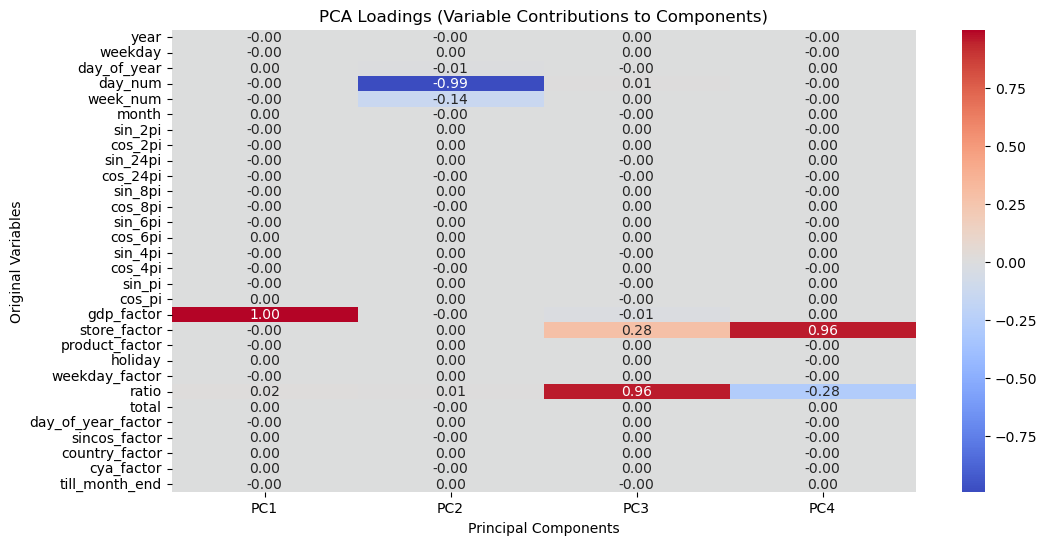

Total Explained Variance:

0.9990333561636197


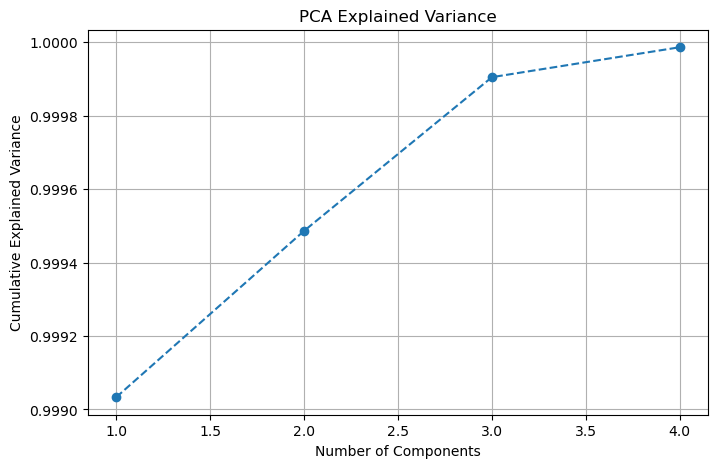

                            OLS Regression Results                            
Dep. Variable:               num_sold   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 3.594e+06
Date:                Tue, 25 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:49:16   Log-Likelihood:            -1.0219e+06
No. Observations:              176800   AIC:                         2.044e+06
Df Residuals:                  176795   BIC:                         2.044e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        770.3737      0.186   4134.227      0.0

In [16]:
# Final dataset with 4 principal components
X_train, X_val, y_train, y_val, loadings = load_train_val_splits_with_pca(data_path="transformed_features.csv", n_components=4)

# Agregate the constant
X_train_const = sm.add_constant(X_train)

# Fit the linear regression model
lm_model = sm.OLS(y_train, X_train_const).fit()

# Summary
print(lm_model.summary())

The components are statistically significant (under the assumption that the hypotheses regarding the error term in the linear regression model hold, ensuring valid inference)

### Decision Tree to study the importance of the principal components 

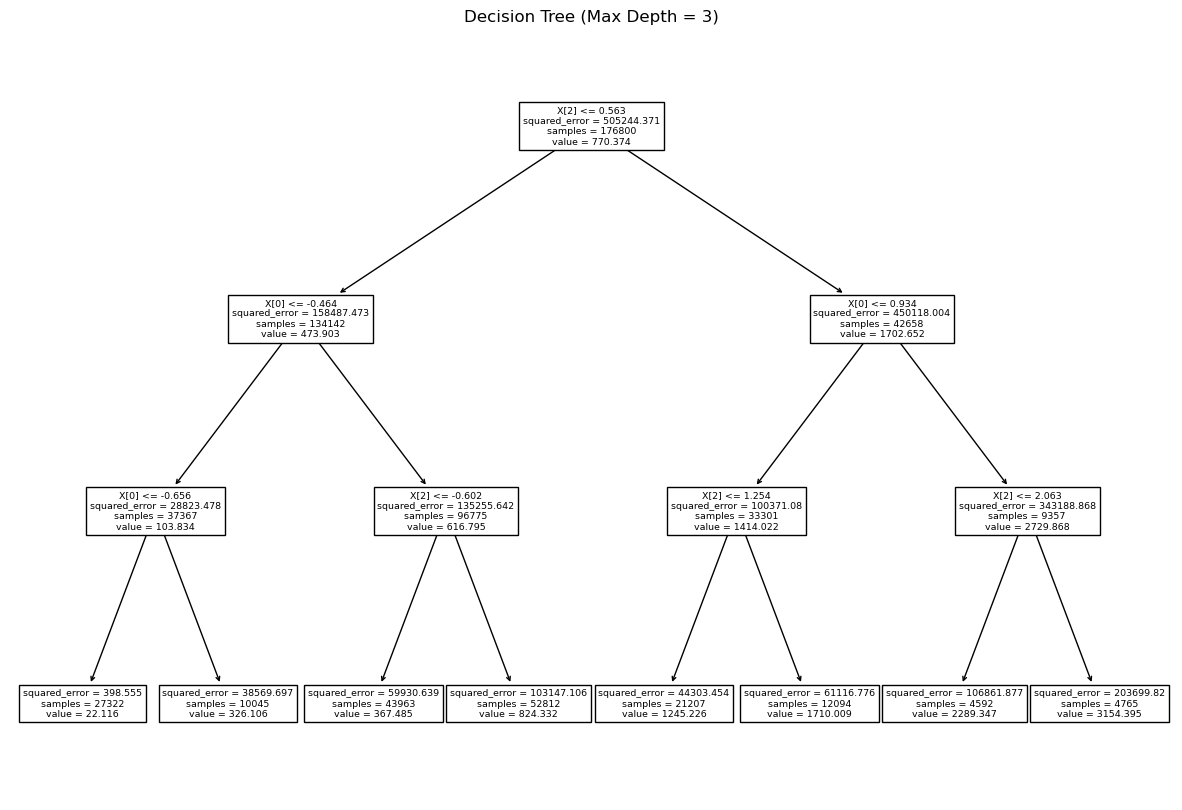

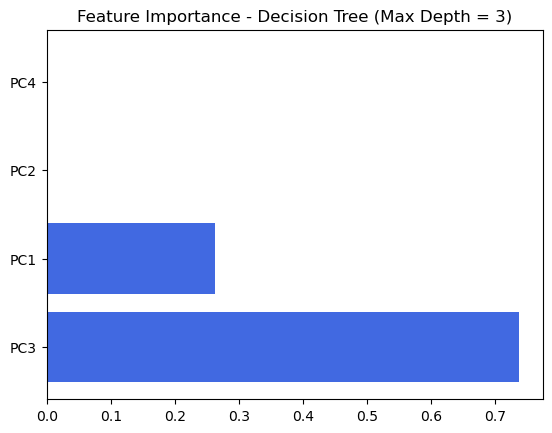

In [17]:
# Decision tree for visualization (max_depth small)
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X_train, y_train)

#Visualize
plt.figure(figsize=(15, 10))
tree.plot_tree(tree_model);
plt.title("Decision Tree (Max Depth = 3)")
plt.show()

# Feauture importance
feature_importance_tree = tree_model.feature_importances_

# Visualize
feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Tree Importance': feature_importance_tree,
    }).sort_values(by='Tree Importance', ascending=False)


plt.barh(feature_importance_df['Feature'], feature_importance_df['Tree Importance'], color='royalblue')
plt.title('Feature Importance - Decision Tree (Max Depth = 3)')

plt.show()

Greater importance for component 3 (Sales Performance Ratio Factor, around 70%), followed by component 1 (Economic Factor, around 30%).

In [18]:
#We also calculate the error metrics
validate_model(tree_model,X_val,y_val)

Mean Squared Error: 51735.685167173266
Mean Absolute Error: 162.7487341706168
R^2 Score: 0.8542755683358572
Mean Absolute Percentage Error 0.47661730797422824


{'mse': 51735.685167173266,
 'mae': 162.7487341706168,
 'r2': 0.8542755683358572,
 'mape': 0.47661730797422824}

### Trying some models of 3-Models script

Although the main objective of performing PCA was not specifically for prediction, we will evaluate the predictive capability of using the four principal components as explanatory variables in the models calibrated in the script 3-Models

In [36]:
pred_df, error_metrics_train, error_metrics_val = get_model_predictions_df(my_model_list)
pred_df

Mean Squared Error: 4829.301525317733
Mean Absolute Error: 39.09737944096033
R^2 Score: 0.9863972571767883
Mean Absolute Percentage Error 0.0647286949414875

 xgboost_regression_ensemble_pca
Mean Squared Error: 4829.301525317733
Mean Absolute Error: 39.09737944096033
R^2 Score: 0.9863972571767883
Mean Absolute Percentage Error 0.0647286949414875
Mean Squared Error: 2925.033612690105
Mean Absolute Error: 31.89193125023694
R^2 Score: 0.9942106557082947
Mean Absolute Percentage Error 0.051888242449519166
Mean Squared Error: 4478.25143592382
Mean Absolute Error: 37.87151180661008
R^2 Score: 0.9873860635412401
Mean Absolute Percentage Error 0.06340638763057886

 random_forest_regression_ensemble_pca
Mean Squared Error: 4478.25143592382
Mean Absolute Error: 37.87151180661008
R^2 Score: 0.9873860635412401
Mean Absolute Percentage Error 0.06340638763057886
Mean Squared Error: 3666.1441664079325
Mean Absolute Error: 34.97844508921047
R^2 Score: 0.9927438198623493
Mean Absolute Percentage Error 

,xgboost_regression_ensemble_pca,random_forest_regression_ensemble_pca,xgboost_rf_bagging_ensemble_pca,XGBRegressor_pca,LinearRegression_pca,DecisionTreeRegressor_pca,BaggingEnsemble_pca
0,713.697358,720.695975,701.752415,718.265198,689.128972,659.966934,711.059900
1,573.270471,584.381840,571.583952,594.506104,561.704723,570.644444,571.986581
2,339.742998,343.590157,335.129370,346.075592,329.768612,373.717066,343.950970
3,313.511599,318.699272,311.885780,318.063690,305.615206,373.717066,322.151705
4,1464.722738,1463.537917,1452.858985,1457.088867,1389.669111,1396.000000,1467.099187
...,...,...,...,...,...,...,...
44454,361.180140,355.373681,352.785032,326.111786,345.540047,281.101518,345.238303
44455,2189.882892,2224.280044,2230.228857,2213.187988,2181.554790,2244.142857,2211.828813
44456,1735.608623,1726.191855,1751.414714,1690.717407,1660.681583,1702.070522,1736.510862
44457,1016.628816,1027.494857,1024.944064,1022.541077,979.258878,975.250992,1038.126545


In [38]:
#store predictions + error_metrics
predictions_path = "predictions_df_pca.csv"
pred_df.to_csv(predictions_path)
error_metrics_train_path = "metrics_train_pca.csv"
error_metrics_val_path = "metrics_val_pca.csv"
error_metrics_train.to_csv(error_metrics_train_path)
error_metrics_val.to_csv(error_metrics_val_path)